In [3]:
%reload_ext autoreload
%autoreload 2
import tie.dbutils as db
import tie.utils as qa
import pandas as pd
from scipy.io import savemat, loadmat
import json
from tqdm import tqdm
import os
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
import numpy as np
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import DivergingNorm, TwoSlopeNorm
from statsmodels.stats.multitest import fdrcorrection
import matplotlib.patches as patches

In [4]:
rc('font', **{'family':'sans-serif',
              'sans-serif':['Helvetica']})
FONT_SIZE = 25
params = {'axes.labelsize': FONT_SIZE,
          'axes.titlesize': FONT_SIZE, 
          'legend.fontsize': FONT_SIZE, 
          'xtick.labelsize': FONT_SIZE, 
          'ytick.labelsize': FONT_SIZE}
matplotlib.rcParams.update(params)

In [59]:
all_age = loadmat('../../all_age_516_log_NORM.mat')['all_age'][0][0].flat[0]
len(all_age)
A = all_age[5].squeeze()
B = all_age[6].squeeze()
betas = all_age[7].squeeze()

In [60]:
Y_hat = B @ betas.T
residual = A - Y_hat

# Panel a

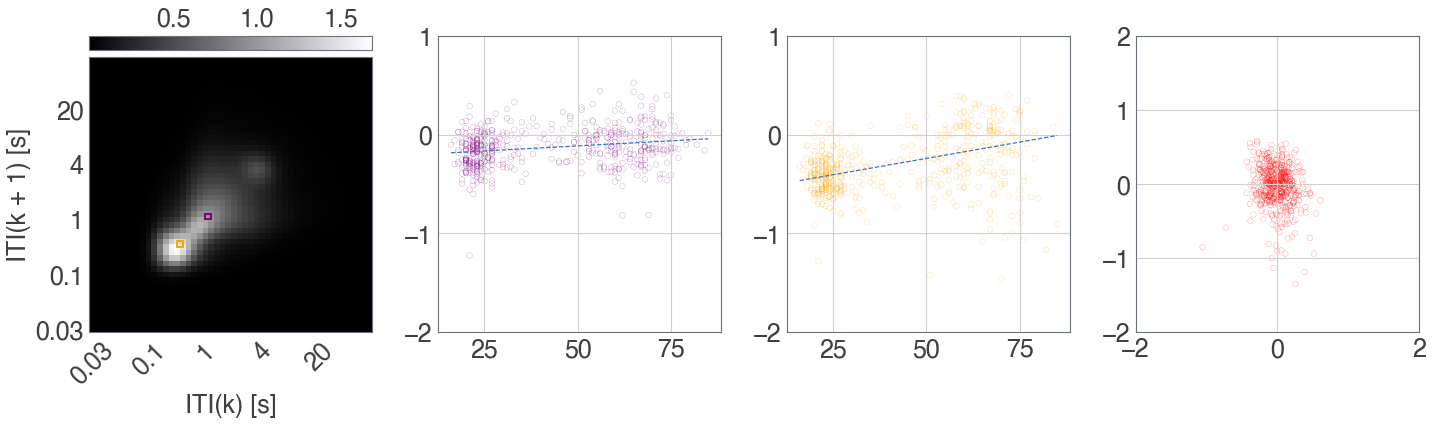

In [83]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6))

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

im = ax[0].imshow(10 ** A[0].reshape(50, 50), aspect='auto', cmap='gray')
ax[0].invert_yaxis()
ax[0].set_xticks(ticks)
ax[0].set_xticklabels(labels)
ax[0].xaxis.set_tick_params(rotation=45)
ax[0].set_yticks(ticks)
ax[0].set_yticklabels(labels)
ax[0].set_xlabel('ITI(k) [s]')
ax[0].set_ylabel('ITI(k + 1) [s]')
ax[0].grid(False)
divider = make_axes_locatable(ax[0])
cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
fig.add_axes(cax)
cb = fig.colorbar(im, cax=cax, orientation="horizontal")
cb.ax.xaxis.set_ticks_position('top')

X1, Y1 = 20, 20
X2, Y2 = 15, 15

rect1 = patches.Rectangle((X1, Y1), 1, 1, linewidth=2, edgecolor='purple', facecolor='none')
rect2 = patches.Rectangle((X2, Y2), 1, 1, linewidth=2, edgecolor='orange', facecolor='none')
ax[0].add_patch(rect1)
ax[0].add_patch(rect2)

for i, (_X, _Y, _color) in enumerate(zip([X1, X2], [Y1, Y2], ['purple', 'orange'])):

    idx1 = _X * 50 + _Y
    _y = A[:, idx1]
    _x = B[:, 0]
    _k = betas[idx1]
    ax[i + 1].scatter(_x, _y, facecolors='none', edgecolors=_color)
    ax[i + 1].plot([min(_x), max(_x)], np.array([min(_x), max(_x)]) * _k[0] + _k[1], '--b')
    ax[i + 1].set_ylim([-2, 1])

idx1 = X1 * 50 + Y1
idx2 = X2 * 50 + Y2
ax[3].scatter(residual[:, idx1], residual[:, idx2], facecolors='none', edgecolors='red')
ax[3].set_xlim([-2 , 2])
ax[3].set_ylim([-2 , 2])
plt.tight_layout()
plt.savefig('figure_2_panel_a.pdf', transparent=True)

# Panel b

In [17]:
for_conn = loadmat('../../connectionist_full_jid.mat')
F_vals = for_conn['F_vals']
print(F_vals.shape)
p_vals = for_conn['p_vals']
print(p_vals.shape)
R_vals = for_conn['R_vals']
print(R_vals.shape)
R2_vals = for_conn['R2_vals']
print(R2_vals.shape)
mask = for_conn['mask']
print(mask.shape)
all_R_a = for_conn['all_R_a']
print(all_R_a.shape)
betas = for_conn['betas']
print(betas.shape)

all_age_gender = loadmat('../../all_age_gender_log_NORM_v3.mat')['all_age_gender'][0]
mdl = all_age_gender[0].flat[0][2]

betas = np.zeros((2500, 1))
for j, obj in enumerate(mdl):
    pixel = obj.flat[0][0][0]
    betas[j] = pixel[3].squeeze()[0]

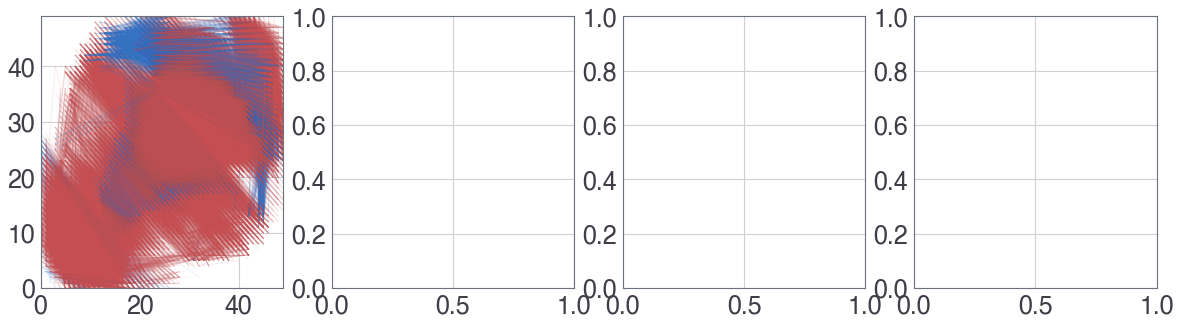

In [31]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

min_dist_pix = 5;
th_dist = min_dist_pix * np.sqrt(2);
th_R = 0.8;
th_F = 5;

for kk in range(1):
    for i in range(2500):
        for j in range(i + 1, 2500):
            if (abs(R_vals[i, j]) > th_R) & (F_vals[i, j] > th_F) & (mask[i, j] == 1):
                x1 = i % 50
                y1 = i  // 50
                x2 = j % 50
                y2 = j // 50
                if np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2) > th_dist:
                    if np.sign(betas[i]) != np.sign(betas[j]):
                        ax[kk].plot([x1, x2], [y1, y2], '-b', alpha=0.1, linewidth=1)
                    else:
                        ax[kk].plot([x1, x2], [y1, y2], '-r', alpha=0.1, linewidth=1)
    ax[kk].set_xlim([0, 49]);
    ax[kk].set_ylim([0, 49]);

# Divide betas >< 0

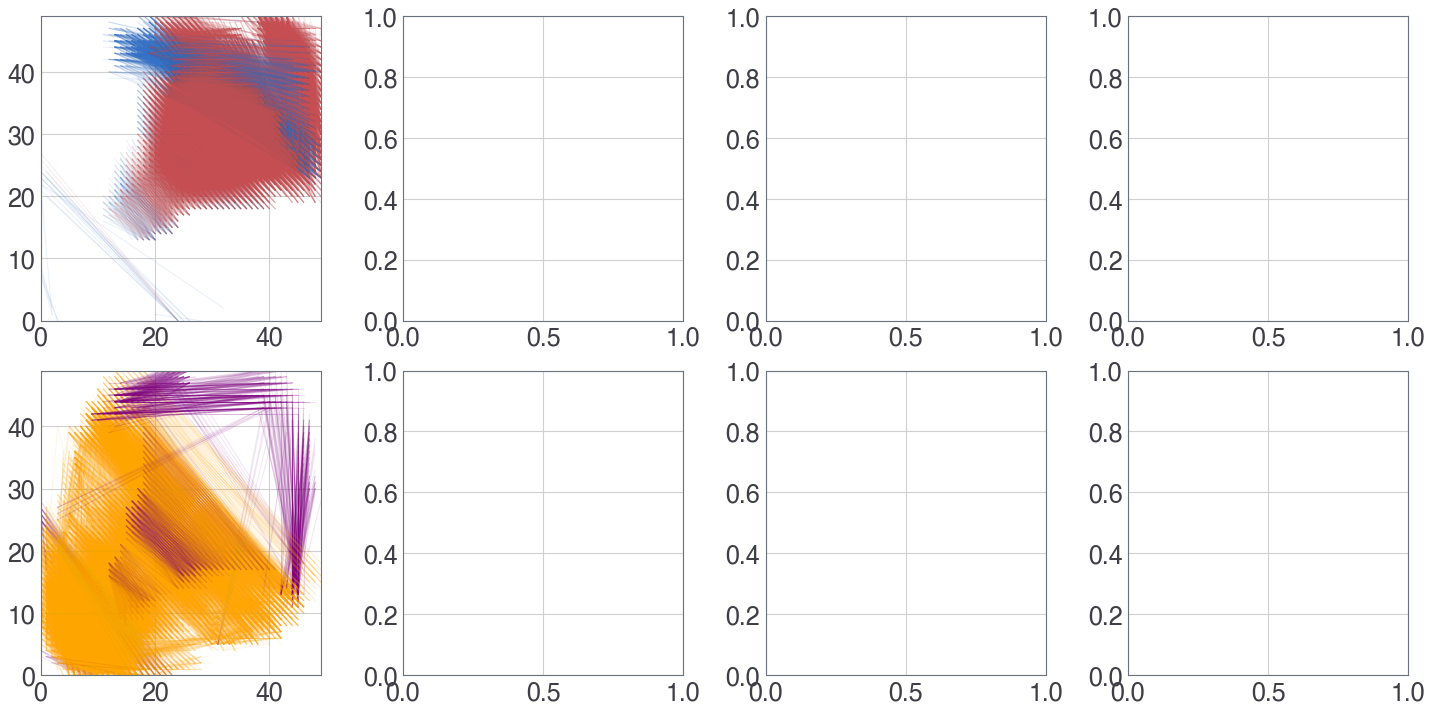

In [36]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

min_dist_pix = 5;
th_dist = min_dist_pix * np.sqrt(2);
th_R = 0.8;
th_F = 5;

for kk in range(1):
    for i in range(2500):
        for j in range(i + 1, 2500):
            if (abs(R_vals[i, j]) > th_R) & (F_vals[i, j] > th_F) & (mask[i, j] == 1):
                x1 = i % 50
                y1 = i  // 50
                x2 = j % 50
                y2 = j // 50
                if np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2) > th_dist:
                    if betas[i] > 0:
                        if np.sign(betas[i]) != np.sign(betas[j]):
                            ax[0][kk].plot([x1, x2], [y1, y2], '-b', alpha=0.1, linewidth=1)
                        else:
                            ax[0][kk].plot([x1, x2], [y1, y2], '-r', alpha=0.1, linewidth=1)
                    else:
                        if np.sign(betas[i]) != np.sign(betas[j]):
                            ax[1][kk].plot([x1, x2], [y1, y2], '-', color='purple', alpha=0.1, linewidth=1)
                        else:
                            ax[1][kk].plot([x1, x2], [y1, y2], '-', color='orange', alpha=0.1, linewidth=1)
    ax[0][kk].set_xlim([0, 49]);
    ax[0][kk].set_ylim([0, 49]);
    ax[1][kk].set_xlim([0, 49]);
    ax[1][kk].set_ylim([0, 49]);
    
plt.tight_layout()